# Fractal Generation

## CPU and Numpy

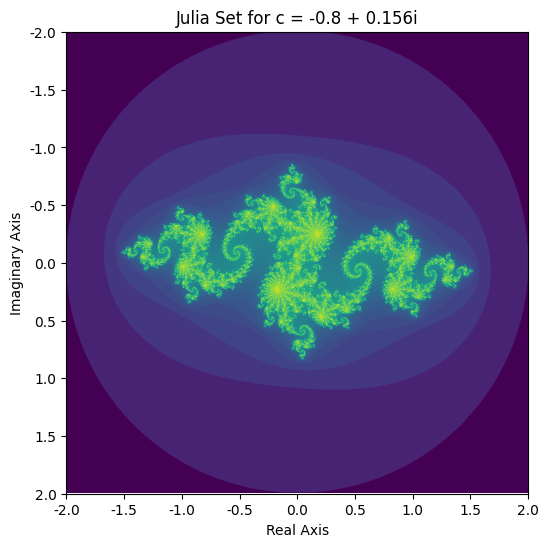

In [4]:
import numpy as np
import matplotlib.pyplot as plt

SIZE=768
EPS=1e-6
RE,IM = 0,1  # indexing into a manual complex value (i.e.  c[RE], c[IM] )



# Use a pre-computed mesh as input, created outside this method so it doesn't need to
# be reallocated & recomputed for each call
def cpu_zn2plusc(np_zmesh_re, np_zmesh_im, c_real, c_imag):

    # Create output image buffer
    nr, nc = np_zmesh_re.shape
    out = np.zeros((nr, nc))
    max_escape_iter = 1000

    # Iterate over all pixels, using its point in the complex plane as the starting z-value
    for r in range(nr):
        for c in range(nc):

            # The starting z-value for pixel[r,c] is z = a + bi
            a = np_zmesh_re[r, c]
            b = np_zmesh_im[r, c]

            temp_real, temp_imag = 0,0

            for iter in range(1, max_escape_iter):
                if a*a + b*b > 4.0:
                    # Once the squared magnitude is >4.0, it's never coming back
                    break
                else:
                    # (a + bi) * (a + bi) == (a*a - b*b) + (2*a*b)i
                    temp_real = a*a - b*b + c_real
                    temp_imag = 2*a*b + c_imag
                    a = temp_real
                    b = temp_imag

            out[r, c] = np.log2(float(iter)) / np.log2(max_escape_iter)

    return out


# Quick helper function to rescale axes to complex values.  In this case we use r~real, i~imaginary
def relabel_axes(ax, nr=768, rmin=-2, rmax=2, ni=768, imin=-2, imax=2):
    r_width = rmax - rmin
    new_rticks = np.arange(0, nr+1, nr//8, dtype=np.int32).tolist()
    new_rticklabels = [f'{r_width * t / nr + rmin:.1f}' for t in new_rticks]
    ax.set_xticks(new_rticks)
    ax.set_xticklabels(new_rticklabels)
    ax.set_xlabel('Real Axis')

    i_width = imax - imin
    new_iticks = np.arange(0, ni+1, ni//8, dtype=np.int32).tolist()
    new_iticklabels = [f'{i_width * t / ni + imin:.1f}' for t in new_iticks]
    ax.set_yticks(new_iticks)
    ax.set_yticklabels(new_iticklabels)
    ax.set_ylabel('Imaginary Axis')




# Constant mesh is the same for all inputs (represent grid in complex plane)
zmesh_real, zmesh_imag = np.meshgrid(
    np.arange(-2, 2, (4 + EPS) / (SIZE -1)),
    np.arange(-2, 2, (4 + EPS) / (SIZE -1))[::-1])


a, b = -0.8, 0.156

cpu_fractal = cpu_zn2plusc(zmesh_real, zmesh_imag, a, b)
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(cpu_fractal)
ax.set_title(f'Julia Set for c = {a:.1f} + {b:.3f}i')
relabel_axes(ax)

# 2. GPU Implementation

**Notice the switch from `np` methods to nearly identical `cp` methods**

In [ ]:
# Create a GPU/CuPy grid of complex values (`cp.*` instead of `np.*`)
zmesh_re, zmesh_im = cp.meshgrid(
    cp.arange(-2, 2, (4 + EPS) / SIZE),
    cp.arange(-2, 2, (4 + EPS) / SIZE)[::-1])

### Define the CUDA Kernel using CuPy `ElementwiseKernel`

Everytime we run the following cell, we are generating C++ code that has to be compiled into a CUDA kernel and then uploaded to the GPU.  If we were to create a loop or interactive method with this code inline, we're going to take a devastating performance hit, since it will have to recompile and upload the code for every fractal generation.

So the strategy is to create the `cp.ElementwiseKernel` one time, which compiles and pushes the code to the GPU to be invoked by downstream code repeatedly.  The meshes supplied as the first two arguments were already created on the GPU (in the previous cell), so under the hood it's only passing the existing pointers to GPU memory for those inputs, not copying the data.  The other two arguments are the single complex `c`-value that define the fractal we want to generate.  Therefore, when we invoke this method the only thing being sent to the GPU is a couple of GPU memory pointers and two float32 values.  It doesn't get any more efficient & optimized than that.


In [ ]:
# Define the C++ code to be compiled into the CUDA grid/block kernel
gpu_escape_time_zn_plus_c = cp.ElementwiseKernel(
    'float32 z_mesh_re, float32 z_mesh_im, float32 cReal, float32 cImag',
    'float32 out',
    '''
        int time;

        float tempReal = 0.0;
        float tempImag = 0.0;

        float znReal = z_mesh_re;
        float znImag = z_mesh_im;

        for(time=1; time<1000; time++)
        {
            if(znReal*znReal + znImag*znImag > 4.0)
                break;
            else
            {
                tempReal = znReal*znReal - znImag*znImag + cReal;
                tempImag = 2*znReal*znImag + cImag;

                znReal = tempReal;
                znImag = tempImag;
            }
        }

        out = log2f((float)time) / log2f(1000.0f);
    ''',
    'gpu_znplusc')

In [ ]:
# Create the mesh inputs directly on the GPU with cp.meshgrid(...)
zmesh_re, zmesh_im = cp.meshgrid(cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32),
                                 cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32))

# A quick test to confirm it runs and produces the output shape we expected
out = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -0.8, 0.156)
print('Test run output shape:', out.shape)

In [ ]:
# Show some samples
c_vals = [(-0.8,   0.156),
          (-0.2,  -0.4),
          (-0.4,   0.6),
          ( 0.4,  -0.1)]

fig,axs = plt.subplots(2,2, figsize=(8,8))
for i, (a,b) in enumerate(c_vals):
    out = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, a, b)
    axs[i//2][i%2].imshow(out.get())
    axs[i//2][i%2].set_title(f'c-value = {a:.2f} + {b:.2f}i')
    axs[i//2][i%2].axis('off')


In [ ]:
c_vals = [(-0.8,   0.156),
          (-0.2,  -0.4),
          (-0.4,   0.6),
          ( 0.4,  -0.1)]


fig,axs = plt.subplots(1,4, figsize=(16, 4))
for i, (re, im) in enumerate(c_vals):
    out = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, re, im)
    axs[i].imshow(out.get())
    axs[i].set_title(f'c-value = {re:.2f} + {im:.2f}i')
    axs[i].axis('off')
